# cdli_cat_2_factgrid

__Start Date:__ Jan 25, 2022

__Author:__ Julia Wang & Adam Anderson

__Goal:__ Converting the daily data dump of CDLI in [cdli_cat.csv](https://media.githubusercontent.com/media/cdli-gh/data/master/cdli_cat.csv) to quick statement in FactGrid.

__CSV:__ [cdli_cat_2_factgrid.csv]() (insert link here when ready)

--------------------------------

__To do for Version 1.0:__

* Read in the CDLI_CAT data

* Select Desired Columns for FactGrid Q-ids:

    * Language
    * Material
    * Museum
    * Provenience
    * Object type
    * Genre
    * Period 

* Concatenate
* QuickStatements
* Next Steps

Just to foreshadow what we are looking at (when finished, see section IV for complete list):

We will export the resulting data frame as a CSV with the following fields (plust those listed below in section IV):

| HEADER | qid | Len | Den | P694 | P18 | P121 | P695 | P131 |
| ------ | ---- | --------------- | --------------- | --------- | -------------- | ---- | ---- | --- | 
| LOD | (check agianst FG) | designation | (if we can't get this we can make it): | external_id | language | genre | provenience | (always include) |
| (NOTES) | (otherwise leave blank) | (add Lde and Lfr) | (Lang + Object + provenience + period) | CDLI P-number | Q# | Q#| Q# | Q38597 |



In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import collections

## I. Read in the Data

In [2]:
url = 'https://media.githubusercontent.com/media/cdli-gh/data/master/cdli_cat.csv'

data = pd.read_csv(url, sep=',')
data.head(6)

<ipython-input-2-80a120bf1dfb>:3: DtypeWarning: Columns (1,2,3,4,6,8,9,10,11,14,16,17,19,22,23,24,25,26,27,28,29,31,32,33,37,39,42,45,46,49,52,53,54,55,57,58,59,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url, sep=',')


,accession_no,accounting_period,acquisition_history,alternative_years,ark_number,atf_source,atf_up,author,author_remarks,cdli_collation,...,seal_information,stratigraphic_level,subgenre,subgenre_remarks,surface_preservation,text_remarks,thickness,translation_source,width,object_remarks
0,NaN,NaN,NaN,NaN,21198/zz001q0dtm,"Englund, Robert K.",NaN,CDLI,"31x61x18; Lú A 14-16.30-32.48-50; M XVIII, auf...",NaN,...,NaN,NaN,Archaic Lu2 A (witness),NaN,NaN,NaN,18,no translation,61,NaN
1,NaN,NaN,NaN,NaN,21198/zz001q0dv4,"Englund, Robert K.",NaN,CDLI,30x48x13; Lú A 13-15.23-25.?; Fundstelle wie W...,NaN,...,NaN,NaN,Archaic Lu2 A (witness),NaN,NaN,NaN,13,no translation,48,NaN
2,NaN,NaN,NaN,NaN,21198/zz001q0dwn,"Englund, Robert K.",NaN,"Englund, Robert K. & Nissen, Hans J.","42x53x19; Vocabulary 9; Qa XVI,2, unter der Ab...",NaN,...,NaN,NaN,Archaic Vocabulary (witness),Text category: 15-09; Foreign ID: LVO 9,NaN,NaN,19,no translation,53,NaN
3,NaN,NaN,NaN,NaN,21198/zz001q0dx5,"Englund, Robert K.",NaN,CDLI,26x23x23; Lú A 9-10.?.?; Fundstelle wie W 9123...,NaN,...,NaN,NaN,Archaic Lu2 A (witness),NaN,NaN,NaN,23,no translation,23,NaN
4,NaN,NaN,NaN,NaN,21198/zz001q0dzp,"Englund, Robert K.",NaN,CDLI,"29x36x20; Lú A Vorläufer; Qa XVI,2, unter der ...",NaN,...,NaN,NaN,Archaic Lu2 A (witness),NaN,NaN,NaN,20,no translation,36,NaN
5,NaN,NaN,NaN,NaN,21198/zz001q0f0p,"Englund, Robert K.",NaN,CDLI,82x62x19; Lú A Vorläufer; Fundstelle wie W 912...,NaN,...,NaN,NaN,Archaic Lu2 A (witness),NaN,NaN,NaN,19,no translation,62,NaN


In [3]:
data = data.fillna('-')

The columns in the cdli data dump are as below:

In [4]:
data.columns

Index(['accession_no', 'accounting_period', 'acquisition_history',
       'alternative_years', 'ark_number', 'atf_source', 'atf_up', 'author',
       'author_remarks', 'cdli_collation', 'cdli_comments', 'citation',
       'collection', 'composite_id', 'condition_description', 'date_entered',
       'date_of_origin', 'date_remarks', 'date_updated', 'dates_referenced',
       'db_source', 'designation', 'dumb', 'dumb2', 'electronic_publication',
       'elevation', 'excavation_no', 'external_id', 'findspot_remarks',
       'findspot_square', 'genre', 'google_earth_collection',
       'google_earth_provenience', 'height', 'id', 'id_text2', 'id_text',
       'join_information', 'language', 'lineart_up', 'material', 'museum_no',
       'object_preservation', 'object_type', 'period', 'period_remarks',
       'photo_up', 'primary_publication', 'provenience', 'provenience_remarks',
       'publication_date', 'publication_history', 'published_collation',
       'seal_id', 'seal_information', 's

## II. Select Desired Columns 

1. We will make a subset of the data from the [cdli_cat.csv](https://github.com/cdli-gh/data/blob/master/cdli_cat.csv) data, which is updated daily in the [cdli-gh/data](https://github.com/cdli-gh/data/blob/master/cdli_cat.csv) GitHub repository.

2. Create a data frame `cdli_cat_df` made up with columns we want to include in linked data, following the CDLI_FGformat described in the google sheet we created for the purpose of obtaining the Qids from FactGrid and Wikidata for linked opend data: [LOD Tablet Dictionary (FG Cuneiform)]((https://docs.google.com/spreadsheets/d/107ly4G5j3im6Hbifqw1HaB66zuqzf7ijN6q8A-WvH8s/edit#gid=1318719558)).

In [5]:
cdli_cat_df = pd.DataFrame({'id_text': [], 'external_id': [], 'genre': [], 'subgenre': [], 'subgenre_remarks': [], 
                           'language': [], 'material': [], 'object_type': [], 'period': [], 
                           'atf_source': [], 'author': [], 'author_remarks': [], 'publication_history': [], 
                           'primary_publication': [], 'designation': [], 'publication_date': [], 'provenience': [], 
                           'collection': [], 'museum_no': [], 'accession_no': [], 'height': [], 'thickness': [], 'width': [],
                           'object_remarks': [], 'date_of_origin': [], 'translation_source': [], 'date_entered': [],
                           'dates_referenced': [], 'seal_id': [], 'accounting_period': [], 'citation': []
                            })

desired_columns = cdli_cat_df.columns
not_covered_columns = []

for col in desired_columns:
    # if a desired column is found in data, directly use that column in data
    if col in data.columns:
        cdli_cat_df[col] = data[col]
    # if a desired column is not found in data, record the column name
    else:
        not_covered_columns += [col]


cdli_cat_df = cdli_cat_df.fillna('')
cdli_cat_df


,id_text,external_id,genre,subgenre,subgenre_remarks,language,material,object_type,period,atf_source,...,thickness,width,object_remarks,date_of_origin,translation_source,date_entered,dates_referenced,seal_id,accounting_period,citation
0,1,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk III (ca. 3200-3000 BC),"Englund, Robert K.",...,18,61,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-
1,2,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk III (ca. 3200-3000 BC),"Englund, Robert K.",...,13,48,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-
2,3,-,Lexical,Archaic Vocabulary (witness),Text category: 15-09; Foreign ID: LVO 9,undetermined,clay,tablet,Uruk IV (ca. 3350-3200 BC),"Englund, Robert K.",...,19,53,-,-,no translation,12/4/2001,-,-,-,-
3,4,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk IV (ca. 3350-3200 BC),"Englund, Robert K.",...,23,23,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-
4,5,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk IV (ca. 3350-3200 BC),"Englund, Robert K.",...,20,36,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353278,532443,-,Legal,-,-,Sumerian,clay,tablet,Old Babylonian (ca. 1900-1600 BC),no atf,...,-,-,-,-,no translation,8/13/2022,-,-,-,-
353279,532444,-,Administrative,-,-,Akkadian,clay,tablet,Old Babylonian (ca. 1900-1600 BC),no atf,...,20,34,-,-,no translation,8/13/2022,-,-,-,-
353280,532445,-,Administrative,-,-,Akkadian,clay,tablet,Old Babylonian (ca. 1900-1600 BC),no atf,...,20,34,-,-,no translation,8/13/2022,-,-,-,-
353281,532446,-,Legal,-,-,Akkadian,clay,tablet & envelope,Old Babylonian (ca. 1900-1600 BC),no atf,...,-,-,-,-,no translation,8/19/2022,-,-,-,-


We can see that all desired columns except for the ones below are available in `data` (cdli daily data dump).

In [6]:
not_covered_columns

[]

Next, we need to convert the content of the desired columns into FG formats. An example of FG can be found [here](https://database.factgrid.de/wiki/Item:Q471142). The rules for conversion is documented in the [demo_FGformat](https://docs.google.com/spreadsheets/d/107ly4G5j3im6Hbifqw1HaB66zuqzf7ijN6q8A-WvH8s/edit#gid=349399460) in the LOD Tablet Dictionary.





### 1 __Language = Language [(P18)](https://database.factgrid.de/wiki/Property:P18) + uncertainty [(P155)](https://database.factgrid.de/wiki/Property:P155)__
Start with one statement per text: every text should have at least one language associated with it. For example:

| Lang | P18 | P155 | Lang2 | P18 | 
| ---- | ------ | ---- | ---- | --- |
| Akkadian | [Q471146](https://database.factgrid.de/wiki/Item:Q471146) | [Q22757 questionable statement](https://database.factgrid.de/wiki/Item:Q22757)| Sumerian |[Q471149](https://database.factgrid.de/wiki/Item:Q471149)|

####1.1. We can use [this CSV](https://drive.google.com/file/d/13Zl7KfXJfn-VbAxLd_EcjTDFCgfV9LtD/view?usp=share_link) for matching CDLI label to the FactGrid Q-id:

In [7]:
lang_url = 'https://github.com/ancient-world-citation-analysis/CDLI2LoD/blob/main/data/Language%20-%20LOD%20Tablet%20Dictionary%20(FG%20Cuneiform).csv?raw=true'

lang_reference = pd.read_csv(lang_url, sep = ',')
# drop the first row that is empty
lang_reference = lang_reference.iloc[1: , :]
# drop the sequence column
lang_reference = lang_reference.drop(columns = ['Sequence'])
# fill na values with space
lang_reference = lang_reference.fillna('')
# drop duplicated rows
lang_reference = lang_reference.drop_duplicates(keep = "first")
# use only rows with a QID
lang_reference = lang_reference[lang_reference['FG_item'] != ''].reset_index()
lang_reference

,index,Parent,Language,FG_item
0,10,Elamite,Elamite,Q500430
1,12,Hurrian,Hurrian,Q512052
2,13,Hittite,Hittite,Q500429
3,14,Hittite,Hittite Logographic,Q500429
4,15,Ugaritic,Ugaritic,Q500431
5,17,Arabic,Arabic,Q389598
6,18,Aramaic,Aramaic,Q393615
7,19,Akkadian,Eblaite,Q471146
8,20,Greek,Greek,Q172951
9,21,Hebrew,Hebrew,Q389600


####1.2. Make a data frame `language_df`, which includes all texts that have a lanaguage label with a FactGrid Q-id

####1.3. Make a second column to mark uncertainty [(P155)](https://database.factgrid.de/wiki/Property:P155), for any texts which have a question mark after the language in the cdli_cat data (see above).

####1.4. For entries / texts which have multiple langauges, include an additional column for the additional languages when they match with a FactGrid Q-id (see table above).

 * Note: For texts with multiple languages (which require multiple statements of the same Property), we will need to add the second statement in the 'next batch' so to speak, i.e. with the data that we left out of the first batch. So in order to add additional statements of the same type we will need to perform a sparql query on the first batch of data to obtain the corresponding q-ids for each item.

In [8]:
language_df = cdli_cat_df[['id_text', 'language']]
language_df.head()

,id_text,language
0,1,undetermined
1,2,undetermined
2,3,undetermined
3,4,undetermined
4,5,undetermined


In [9]:
lang = language_df['language']
lang.unique()

array(['undetermined', 'Sumerian', 'Sumerian ?', 'Akkadian', '-',
       'Sumerian; Akkadian', 'Elamite', 'Akkadian; Elamite', 'Hurrian',
       'Akkadian ?', 'Eblaite', 'Akkadian; Elamite; Persian; Egyptian ?',
       '\x0b', 'Ugaritic', 'undetermined (pseudo)', 'Aramaic',
       'Sumerian; Akkadian (pseudo)', 'no linguistic content',
       'Akkadian; Persian; Elamite; Egyptian ', 'Hebrew', 'Aramaic ?',
       'Akkadian; Aramaic', 'Hebrew ?', 'Greek', 'Phoenician', 'Sabaean',
       'Hittite', 'Akkadian; Egyptian', 'Hurrian ?', 'Qatabanian',
       'uncertain', 'Persian', 'Hittite ?', 'Hittite; Hattic', 'Syriac',
       'Mandaic', 'Hittite; Hurrian', 'uninscribed', 'Akkadian\x0b',
       'Akkadian\x0b\x0b', 'Sumerian; Akkadian ?', 'Egyptian ?',
       'Akkadian; Elamite; Persian', 'Arabic', 'Akkadian; Greek',
       'Urartian', 'Akkadian; Elamite; Persian; Egyptian',
       'Akkadian; Persian', 'Egyptian', 'Luwian',
       'Persian; Elamite; Akkadian', 'Akkadian; Persian; Elamite',
 

Clean the language column.

In [10]:
# remove the '\x0b' patterns
lang = np.array([re.sub('\\x0b', '', string = lang[i]) for i in range(len(lang))])
# there are two different entries of NA, merge them into one
lang[lang == '-'] = ''

# check if the cleaning is working
pd.unique(pd.Series(lang))

array(['undetermined', 'Sumerian', 'Sumerian ?', 'Akkadian', '',
       'Sumerian; Akkadian', 'Elamite', 'Akkadian; Elamite', 'Hurrian',
       'Akkadian ?', 'Eblaite', 'Akkadian; Elamite; Persian; Egyptian ?',
       'Ugaritic', 'undetermined (pseudo)', 'Aramaic',
       'Sumerian; Akkadian (pseudo)', 'no linguistic content',
       'Akkadian; Persian; Elamite; Egyptian ', 'Hebrew', 'Aramaic ?',
       'Akkadian; Aramaic', 'Hebrew ?', 'Greek', 'Phoenician', 'Sabaean',
       'Hittite', 'Akkadian; Egyptian', 'Hurrian ?', 'Qatabanian',
       'uncertain', 'Persian', 'Hittite ?', 'Hittite; Hattic', 'Syriac',
       'Mandaic', 'Hittite; Hurrian', 'uninscribed',
       'Sumerian; Akkadian ?', 'Egyptian ?', 'Akkadian; Elamite; Persian',
       'Arabic', 'Akkadian; Greek', 'Urartian',
       'Akkadian; Elamite; Persian; Egyptian', 'Akkadian; Persian',
       'Egyptian', 'Luwian', 'Persian; Elamite; Akkadian',
       'Akkadian; Persian; Elamite', 'Persian, ', 'Persian; Elamite',
       'Persi

There are entries with "clay" as their language. This is certainly incorrect as clay should be the material of the tablet instead of the language. We will check these entries, remove "clay" from the `language` column, and see if "clay" is recorded in the `material` column.

In [11]:
# get the number of records with this problem
cdli_cat_df[cdli_cat_df['language'] == 'clay'].shape[0]

9

In [12]:
# check their material column
cdli_cat_df[cdli_cat_df['language'] == 'clay']['material'].unique()

array(['clay'], dtype=object)

Since all these records already have "clay" as their material, we do not need to update the `material` column. We just need to remove "clay" from the `language` column:

In [13]:
# update the original dataframe
cdli_cat_df.loc[cdli_cat_df['language'] == 'clay', 'language'] == ''

# check if it has been correctly updated
'clay' in cdli_cat_df['language']

False

In [14]:
# update the lang vector
lang[lang == 'clay'] = ''

# update the language dataframe
language_df['language'] = lang

# check if the language dataframe has been properly cleaned
language_df['language'].unique()

<ipython-input-14-f3299db75105>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language_df['language'] = lang


array(['undetermined', 'Sumerian', 'Sumerian ?', 'Akkadian', '',
       'Sumerian; Akkadian', 'Elamite', 'Akkadian; Elamite', 'Hurrian',
       'Akkadian ?', 'Eblaite', 'Akkadian; Elamite; Persian; Egyptian ?',
       'Ugaritic', 'undetermined (pseudo)', 'Aramaic',
       'Sumerian; Akkadian (pseudo)', 'no linguistic content',
       'Akkadian; Persian; Elamite; Egyptian ', 'Hebrew', 'Aramaic ?',
       'Akkadian; Aramaic', 'Hebrew ?', 'Greek', 'Phoenician', 'Sabaean',
       'Hittite', 'Akkadian; Egyptian', 'Hurrian ?', 'Qatabanian',
       'uncertain', 'Persian', 'Hittite ?', 'Hittite; Hattic', 'Syriac',
       'Mandaic', 'Hittite; Hurrian', 'uninscribed',
       'Sumerian; Akkadian ?', 'Egyptian ?', 'Akkadian; Elamite; Persian',
       'Arabic', 'Akkadian; Greek', 'Urartian',
       'Akkadian; Elamite; Persian; Egyptian', 'Akkadian; Persian',
       'Egyptian', 'Luwian', 'Persian; Elamite; Akkadian',
       'Akkadian; Persian; Elamite', 'Persian, ', 'Persian; Elamite',
       'Persi

In [15]:
first_lang = []
first_lang_qid = []
first_lang_parent = []
P155_lang = [] # when there's a question mark
other_lang = [] # when multiple langauges
no_match_indices = [] # index of the row if there's no match

for index in range(len(language_df['language'])):
  l = language_df['language'][index]
  # remove the space in every entry and split it by ;
  lst = l.replace(' ', '').replace(',', ';').split(';')

  # get the first language
  first_l = lst[0]
  
  # store the remaining languages (if exist) away
  other_lang += [', '.join(lst[1:])]

  # check for uncertainty
  if '?' in first_l:
    P155_lang += ['P155']
    first_l = first_l.replace('?', '')
  else:
    P155_lang += ['']

  # add in qid and parent for the first_l

  # if the language has a QID in FactGrid
  if first_l in lang_reference['Language'].unique():
    # record the language
    first_lang += [first_l]
    # get the corresponding QID (FG_item) and Parent
    i = lang_reference['Language'].tolist().index(first_l)
    first_lang_qid += [lang_reference['FG_item'][i]]
    first_lang_parent += [lang_reference['Parent'][i]]

  # if the language does not have a FactGrid QID, put '' for everything for now
  else:
    first_lang += ['']
    first_lang_qid += ['']
    first_lang_parent += ['']
    no_match_indices += [index]

# append these columns to the dataframe
language_df['first_lang'] = first_lang
language_df['first_lang_qid'] = first_lang_qid
language_df['first_lang_parent'] = first_lang_parent
language_df['P155_lang'] = P155_lang
language_df['other_lang'] = other_lang

# update the names of columns to be clearer
language_df = language_df.rename(columns={'id_text': 'cdli_dump_id', 
                                          'language': 'cdli_dump_language'})

language_df

<ipython-input-15-d9d74c588aad>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language_df['first_lang'] = first_lang
<ipython-input-15-d9d74c588aad>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language_df['first_lang_qid'] = first_lang_qid
<ipython-input-15-d9d74c588aad>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,cdli_dump_id,cdli_dump_language,first_lang,first_lang_qid,first_lang_parent,P155_lang,other_lang
0,1,undetermined,,,,,
1,2,undetermined,,,,,
2,3,undetermined,,,,,
3,4,undetermined,,,,,
4,5,undetermined,,,,,
...,...,...,...,...,...,...,...
353278,532443,Sumerian,Sumerian,Q471149,Sumerian,,
353279,532444,Akkadian,Akkadian,Q471146,Akkadian,,
353280,532445,Akkadian,Akkadian,Q471146,Akkadian,,
353281,532446,Akkadian,Akkadian,Q471146,Akkadian,,


#### check if the computed dataframe makes sense

In [16]:
language_df.shape

(353283, 7)

In [17]:
language_df['first_lang'].unique()

array(['', 'Sumerian', 'Akkadian', 'Elamite', 'Hurrian', 'Eblaite',
       'Ugaritic', 'Aramaic', 'Hebrew', 'Greek', 'Hittite', 'Arabic'],
      dtype=object)

In [18]:
pd.unique(pd.Series(other_lang))

array(['', 'Akkadian', 'Elamite', 'Elamite, Persian, Egyptian?',
       'Akkadian(pseudo)', 'Persian, Elamite, Egyptian', 'Aramaic',
       'Egyptian', 'Hattic', 'Hurrian', 'Akkadian?', 'Elamite, Persian',
       'Greek', 'Elamite, Persian, Egyptian', 'Persian',
       'Elamite, Akkadian', 'Persian, Elamite',
       'Persian, Elamite, Babylonian', 'Babylonian',
       'Persian, ElamiteEgyptian', 'Aramaic?'], dtype=object)

In [19]:
language_df['first_lang_qid'].unique()

array(['', 'Q471149', 'Q471146', 'Q500430', 'Q512052', 'Q500431',
       'Q393615', 'Q389600', 'Q172951', 'Q500429', 'Q389598'],
      dtype=object)

In [20]:
language_df['first_lang_parent'].unique()

array(['', 'Sumerian', 'Akkadian', 'Elamite', 'Hurrian', 'Ugaritic',
       'Aramaic', 'Hebrew', 'Greek', 'Hittite', 'Arabic'], dtype=object)

### 1.5. matched_language_df

Make a separate dataframe for all texts that have a first language that matches languaes that exist in FactGrid.

In [21]:
matched_language_df = language_df[~language_df.index.isin(no_match_indices)]
matched_language_df

,cdli_dump_id,cdli_dump_language,first_lang,first_lang_qid,first_lang_parent,P155_lang,other_lang
662,723,Sumerian,Sumerian,Q471149,Sumerian,,
663,724,Sumerian ?,Sumerian,Q471149,Sumerian,P155,
664,725,Sumerian,Sumerian,Q471149,Sumerian,,
665,726,Sumerian,Sumerian,Q471149,Sumerian,,
666,727,Sumerian,Sumerian,Q471149,Sumerian,,
...,...,...,...,...,...,...,...
353278,532443,Sumerian,Sumerian,Q471149,Sumerian,,
353279,532444,Akkadian,Akkadian,Q471146,Akkadian,,
353280,532445,Akkadian,Akkadian,Q471146,Akkadian,,
353281,532446,Akkadian,Akkadian,Q471146,Akkadian,,


###1.6. no_language_df

Make a separate data frame for all texts not included, `no_language_df`, i.e. those that have no language, or a language with no FactGrid Q-id, or uncertain, etc. This can be exported and checked / supervised by hand.

In [22]:
no_match_df = cdli_cat_df.iloc[no_match_indices]
no_match_df.head()

,id_text,external_id,genre,subgenre,subgenre_remarks,language,material,object_type,period,atf_source,...,thickness,width,object_remarks,date_of_origin,translation_source,date_entered,dates_referenced,seal_id,accounting_period,citation
0,1,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk III (ca. 3200-3000 BC),"Englund, Robert K.",...,18,61,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-
1,2,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk III (ca. 3200-3000 BC),"Englund, Robert K.",...,13,48,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-
2,3,-,Lexical,Archaic Vocabulary (witness),Text category: 15-09; Foreign ID: LVO 9,undetermined,clay,tablet,Uruk IV (ca. 3350-3200 BC),"Englund, Robert K.",...,19,53,-,-,no translation,12/4/2001,-,-,-,-
3,4,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk IV (ca. 3350-3200 BC),"Englund, Robert K.",...,23,23,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-
4,5,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk IV (ca. 3350-3200 BC),"Englund, Robert K.",...,20,36,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-


In [23]:
no_match_df.shape

(99299, 31)

In [24]:
no_match_df.shape[0] + matched_language_df.shape[0] == language_df.shape[0]

True

### 1.7 visualizations

#### Distribution of matched first language

In [25]:
first_l_df = pd.DataFrame(matched_language_df.groupby('first_lang')['first_lang'].count())
first_l_df.index.name = None
first_l_df = first_l_df.reset_index().rename(
    columns = {'index': 'first_language', 
              'first_lang': 'count'}).sort_values(by = 'count', ascending = False)
first_l_df

,first_language,count
9,Sumerian,143362
0,Akkadian,85187
7,Hittite,14673
3,Eblaite,6871
4,Elamite,2702
10,Ugaritic,1107
2,Aramaic,58
5,Greek,9
6,Hebrew,8
8,Hurrian,6


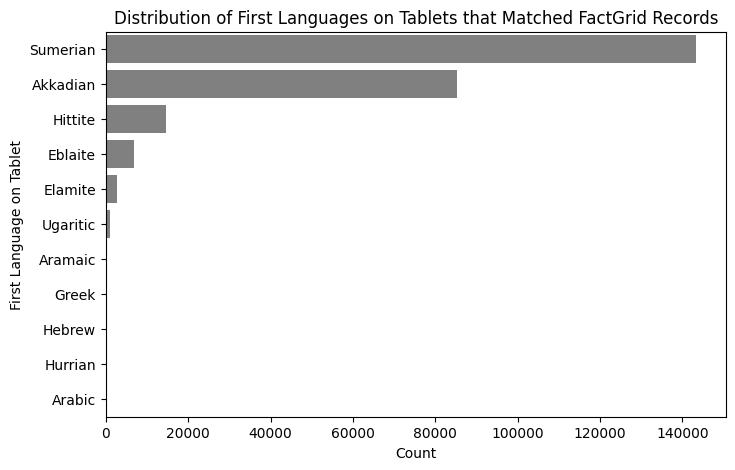

In [26]:
plt.figure(figsize = (8, 5))
sns.barplot(data = first_l_df, y = 'first_language', x = 'count',
            color = 'grey')
plt.xlabel('Count')
plt.ylabel('First Language on Tablet')
plt.title('Distribution of First Languages on Tablets that Matched FactGrid Records');

#### Distribution of unmatched languages

First, take a look at the language of the unmatched rows.

In [34]:
language_df.iloc[no_match_indices].groupby('cdli_dump_language')['cdli_dump_language'].count()

cdli_dump_language
                              90186
Egyptian                          3
Egyptian ?                      186
Luwian                            3
Mandaic                           4
Persian                         125
Persian                           2
Persian,                          1
Persian, Babylonian               3
Persian, Elamite                  2
Persian; Elamite                  2
Persian; Elamite                  2
Persian; Elamite; Akkadian        3
Phoenician                        1
Qatabanian                       11
Sabaean                           1
Syriac                            1
Urartian                          2
no linguistic content           151
uncertain                       111
unclear                           3
undetermined                   8493
undetermined (pseudo)             1
uninscribed                       2
Name: cdli_dump_language, dtype: int64

The reason why we want to visualize the distribution of unmatched languages is to see how many unmatched records there are for each language that does not exist in FactGrid. This way, we can detmermine whether or not we need to create a new object in FactGrid for these languages.

Hence, for the sake of this visualization, we will only consider how many tablets each language has appeared on without keeping track of exactly which tablet that is.

In [54]:
unmatched_langs = language_df.iloc[no_match_indices]['cdli_dump_language']
unmatched_langs_clean = []

for l in unmatched_langs:
  # we only consider the non-empty ones
  if l != '':
    # remove the unceratinty marks
    l = l.replace(' ?', '')

    # make sure that all multiple entries are separated by ;
    l = l.replace(',', ';')

    # split a multi-language statement, if yes
    lst = l.split('; ')

    unmatched_langs_clean += lst

# remove the space attached to some entries which are resulted from splitting by ;
unmatched_langs_clean = [x.rstrip() for x in unmatched_langs_clean]

# remove the empty ones
unmatched_langs_clean.remove('')

pd.unique(pd.Series(unmatched_langs_clean))

array(['undetermined', 'undetermined (pseudo)', 'no linguistic content',
       'Phoenician', 'Sabaean', 'Qatabanian', 'uncertain', 'Persian',
       'Syriac', 'Mandaic', 'uninscribed', 'Egyptian', 'Urartian',
       'Luwian', 'Elamite', 'Akkadian', 'Babylonian', 'unclear'],
      dtype=object)

In [80]:
# get the frequencies of elements in the list
d = collections.Counter(unmatched_langs_clean)

# turn the langs and their counts into a dataframe
unmatched_l_df = pd.DataFrame.from_dict(d, orient = 'index').\
reset_index().\
rename(columns = {'index': 'language', 0: 'count'}).\
sort_values(by = 'count', ascending = False).\
reset_index().\
drop(columns = 'index')

# remove the ones that are already included in FactGrid
for i in range(unmatched_l_df.shape[0]):
  l = unmatched_l_df.loc[i, 'language']
  if l in lang_reference['Language'].unique():
    unmatched_l_df = unmatched_l_df.drop([i])

unmatched_l_df

,language,count
0,undetermined,8493
1,Egyptian,189
2,no linguistic content,151
3,Persian,140
4,uncertain,111
5,Qatabanian,11
7,Mandaic,4
8,Luwian,3
10,Babylonian,3
11,unclear,3


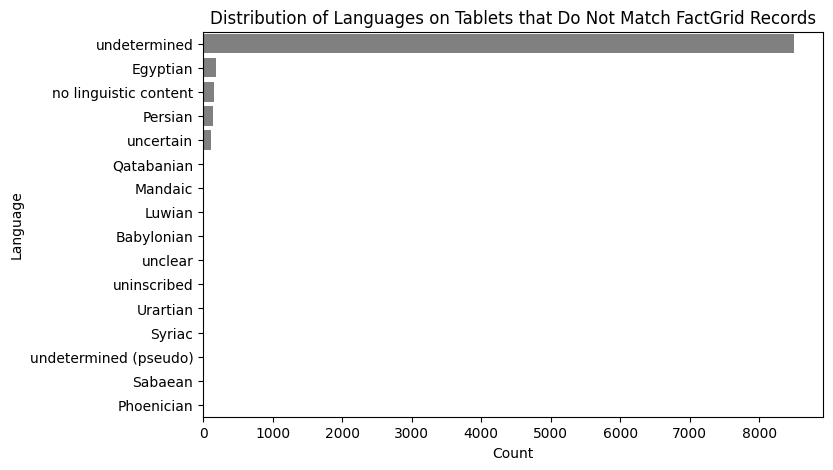

In [82]:
plt.figure(figsize = (8, 5))
sns.barplot(data = unmatched_l_df, y = 'language', x = 'count',
            color = 'grey')
plt.xlabel('Count')
plt.ylabel('Language')
plt.title('Distribution of Languages on Tablets that Do Not Match FactGrid Records');

### 2 __material = material composition [(P401)](https://database.factgrid.de/wiki/Property:P401)__

#### 2.1. We will only add the most basic material composition to a data frame, `material_df', and then we match the first statement to the corresponding FactGrid Q-id.

#### 2.2. Make a second column to mark uncertainty (P155), for any texts which have a question mark after the material in the cdli_cat data (see above)

We can use this CSV to obtain the corresponding FactGrid Q-id:

https://drive.google.com/file/d/12FH9ao4B-U_xIwwjcSoBfOqYoBrgRaJc/view?usp=share_link

In [ ]:
material_url = 'https://github.com/ancient-world-citation-analysis/CDLI2LoD/blob/main/data/Material%20-%20LOD%20Tablet%20Dictionary%20(FG%20Cuneiform).csv?raw=true'

mat_reference = pd.read_csv(material_url, sep = ',')
# fill na values with space
mat_reference = mat_reference.fillna('')
# drop duplicated rows
mat_reference = mat_reference.drop_duplicates(keep = 'first')
mat_reference

,Material,FactGrid_Label,FactGrid_Q
0,?,,
1,bitumen,,
2,bone: bone,Bone,Q512051
3,bone: ivory,Bone,Q512051
4,bone: ivory ?,Bone,Q512051
...,...,...,...
109,stone: steatite,Stone,Q254907
110,stone: travertine,Stone,Q254907
111,stone: tuff,Stone,Q254907
112,stone: volcanic,Stone,Q254907


#### 2.2. Make the `material_df` data frame for material_composition for all items with a matching material composition FactGrid Q-id.

#### 2.3. Make a separate dataframe of the items not matched for export and supervision: `no_material_df`.

In [ ]:
cdli_cat_df['material'].unique()

array(['clay', 'gypsum', 'stone: steatite', 'stone: limestone', 'stone',
       'stone: onyx', 'stone: slate', 'stone: basalt', 'stone: alabaster',
       'clay\x0b', 'stone: agate', 'metal: bronze', 'stone: granite',
       'stone: agate ?', 'stone: diorite', 'stone: alabaster ?', '-',
       'metal', 'stone: calcite', 'stone: marble', 'stone: rock crystal',
       'stone: calcite ?', 'stone ?', 'bitumen', 'metal: copper',
       'stone: dolomite', 'stone: haematite', 'bone: shell',
       'stone: dolerite', 'metal: gold', 'stone: quartz',
       'stone: carnelian', 'metal: bronze ?', 'clay: terracotta',
       'stone: lapis lazuli', 'stone: serpentine', 'stone: hematite',
       'stone: jasper', 'stone: greenstone', 'stone: schist',
       'stone: crystal', 'stone: aragonite', 'stone: diorite ?',
       'stone: gypsum', 'stone: shale', 'stone: limestone ?',
       'stone: syenite', 'stone: gypsum ?', 'metal: silver',
       'stone: hornfels', 'stone: porphyry', 'stone: lava',
       

### 3 __museum = present holding [(P329)](https://database.factgrid.de/wiki/Property:P329)__

####3.1. Next we list all the unique statements in the 'collection' field in a data frame, `museum_df` and match them with the FactGrid Q-ids.

#### 3.2. We can use this dataset, which has the corresponding FactGrid Q-ids: https://drive.google.com/file/d/1uSbm1CGOlFUG5ltAocSOjdb3VTNjFGgs/view?usp=share_link

#### 3.3. Match on cdli label to obtain the corresponding FactGrid Q-id for 'collection' field and add matching data to `museum_df`.

#### 3.4. Include a column / field for the corresponding __'museum_no' = 'inventory position' [(P10)](https://database.factgrid.de/wiki/Property:P10)__.

#### 3.5. Make a separate data frame for the texts when there is no match / museum / collection: `no_museum_df`.

In [ ]:
cdli_cat_df['collection'].unique()

array(['Vorderasiatisches Museum, Berlin, Germany',
       'National Museum of Iraq, Baghdad, Iraq',
       'National Museum of Iraq, Baghdad, Iraq; Vorderasiatisches Museum, Berlin, Germany',
       ..., 'Mardin Museum, Mardin, Turkey', 'Oylum Höyük, Oylum, Turkey',
       'private: William T. Grant Jr., Pelham Manor, New York, USA'],
      dtype=object)

In [ ]:
cdli_cat_df['id_text'].unique()

array([     1,      2,      3, ..., 532445, 532446, 532447])

In [ ]:
museum_df

In [ ]:
no_museum_df

### 4 __provenience = find spot [(P695)](https://database.factgrid.de/wiki/Property:P695)__

####4.1. Use this CSV to obtain the FactGrid Q-ids for each provenience location in the CDLI catalog:

https://drive.google.com/file/d/1C8hj2nVC8_qzFb8HbArbMpsx41OAV9-m/view?usp=share_link

####4.2. Matching can be done either on the cdli 'provenience' label, or on the 'cdli_id2' number [(P694)](https://database.factgrid.de/entity/P694).

####4.3. make a data frame, called `provenience_df`, for all matches of the text's 'provenience' to  FactGrid Q-id for 'find spot'.

#### 4.4 Add two columns as qualifiers:
* 'excavation_no' = [P804](https://database.factgrid.de/entity/P804) Inventory number
* 'findspot_square' = [P425](https://database.factgrid.de/entity/P425) Precision of localisation

####4.5. make a separate data frame of all texts which were not matched (or no location identified): `no_provenience_df`.

In [ ]:
provenience_df

In [ ]:
no_provenience_df

### 5 __object_type = Instance of [(P2)](https://database.factgrid.de/wiki/Property:P2)__

####5.1 Use this CSV to obtain the FactGrid Q-ids for each object type in the CDLI catalog:
https://drive.google.com/file/d/12yQ8rI-_WRSOQIcwV3TBs5xyPRHliFeK/view?usp=share_link

####5.2. Match on the cdli label for 'object_type' to obtain the FactGrid Q-id

####5.3. Make a data frame, called `object_type_df`, for all matches.

####5.4. Make a separate data frame of the texts / artifacts which were not matched: `no_object_type_df`.


In [ ]:
object_type_df

In [ ]:
no_object_type_df

### 6 __genre = Field of Knowledge [(P608)](https://database.factgrid.de/wiki/Property:P608)__

#### 6.1 Use this CSV to obtain the FactGrid Q-ids for each object type in the CDLI catalog:

#### 6.2 Match on the cdli label 'genre' to obtain the FactGrid Q-id.

#### 6.3 Make a data frame, called `genre_df`, for all matches.

#### 6.4. Make a separate data frame of the texts which were not matched: `no_genre_df`.

In [ ]:
genre_df

In [ ]:
no_genre_df

### 7 __period = Period [(P853)](https://database.factgrid.de/wiki/Property:P853)__

#### 7.1 Use this CSV to obtain the FactGrid Q-ids for each period of each texts in the CDLI catalog: https://drive.google.com/file/d/1GCYneZi-SVA49iRfVMP_mH-0LFLRpIaQ/view?usp=share_link
* note that this CSV contains Wikidata Q-ids, along with the begin / end of the other chronologies (high, low, middle, etc.)

####7.2 Match on the CDLI 'period' label to obtain the FactGrid Q-id.

####7.3 Make a data frame, called `period_df`, for all matches.
* if there's a question mark in the CDLI for period, you can use the same method as the `language_df` above, by adding the following column: 

|[(P155)](https://database.factgrid.de/wiki/Property:P155)|
| ------ |
| [Q22757](https://database.factgrid.de/wiki/Item:Q22757)|

####7.4 Make a separate data from of the texts which were not matched: `no_period_df`.

In [ ]:
period_df

In [ ]:
no_period_df

## III. Concatenate resulting matched data frames

Continuing with the cleaned up `cdli_cat_df`, we next want to concatenate the data frames from above, but only those which found the corresponding matches with FactGrid Q-ids. The resulting data frame, called `cdli_cat_2_df` will concatenate the following data frames on the basis of the each text, i.e. 'cdli_id' + 'designation', matching to the following:
1. `language_df`
2. `material_df`
3. `museum_df`
4. `provenience_df`
5. `object_type_df`
6. `genre_df`
7. `period_df`

In [ ]:
cdli_cat_2_df

## IV. Prepare for __FactGrid__ QuickStatement batch processing

Once the `cdli_cat_2_df` is properly joined together (i.e. concatenated), the last step before we export the resulting CSV is to include the FactGrid statements into the data frame, which we will call `cdli_cat_2_factgrid_df`. 

Most of this process is straightforward, but the one statement we need to create is a __description__ for each object. 
###1 To do so we will use a couple of the cleaned up fields from `cdli_cat_2_df` above and add a new field with header 'Den' which will join three existing columns together to form a descriptive sentence.

###2 For each object with a 'cdli_id' + 'designation' we will make the description by joining the following fields:
 * 'lang' +
 * 'genre' +
 * 'object' +
 * " from " +
 * 'provenience = Len' + (the CDLI 'provenience' field has many missing fields, so we will use the 'Len' field instead)
 * ", dated to " +
 * 'period' +
 * " and currently held in the" +
 * 'collection'

###3 The result should look something like this: __"Sumerian administrative tablet from Girsu, dated to Ur III (ca. 2100-2000 BC) and currently held in the British Museum, London, UK"__

###4 The final resulting data frame (`cdli_cat_2_factgrid_df`) will include the following fields, with data from `cdli_cat_2_df` in single quotation marks (' '). This includes a total of 15 columns new columns added at the beginning of the data frame:

#### 4.1 Initial fields with __description__:

| qid | Len | Den | P2 | P131 | P692 |
| --- | --- | --- | ---- | --- | --- |
| (blank) | 'designation' | __description__ | [Q390181](https://database.factgrid.de/wiki/Item:Q390181) (for all) | [Q389597](https://database.factgrid.de/wiki/Item:Q389597) (for all) | 'id_text' |

#### 4.2 __language_df__ (continued):

| Language | P18 | P155 | Lang2 | P18 | 
| ----- |------ | ---- | ---- | --- |
Akkadian (for example) | [Q471146](https://database.factgrid.de/wiki/Item:Q471146) | [Q22757](https://database.factgrid.de/wiki/Item:Q22757) (if questionable)| Sumerian (for example) |[Q471149](https://database.factgrid.de/wiki/Item:Q471149) (for example)|

#### 4.3 __material_df__ (continued):

| Material composition | P401 | 
| ------ | ---- |
|clay (for example) | [Q471153](https://database.factgrid.de/wiki/Item:Q471153) | 

#### 4.4 __museum_df__ (continued):

| Present holding | P329 | P10 + [qualifier](https://database.factgrid.de/wiki/Item:Q499887#) | 
| ------ | ---- | ----------- |
British Museum (for example) | [Q102010](https://database.factgrid.de/wiki/Item:Q102010) | 'museum_no' |

#### 4.5 __provenience_df__ (continued):
| Provenience | P695 | P804 | P425 |
| ----------- | ---- | ---- | ---- |
| 'Len' = Kanesh (for example)| [Q390036](https://database.factgrid.de/wiki/Item:Q390036) | "kt a/k 0353" |  |

  * Note: these qualifiers for 'excavation_no' and 'findspot_square' will make issues for QuickStatements, because there will be a lot of null values. We will need to add these in separate batches.
 

#### 4.6 __object_type_df__ (continued):

| Instance of | P2 |
| ---- | ---- |
| Tablet (for example) | [Q512006](https://database.factgrid.de/wiki/Item:Q512006) |

#### 4.7 __genre_df__ (continued):

| Type of work | P121 | P608 | 
| ---- | ---- | ---- |
| Letter (for example) | [Q10510](https://database.factgrid.de/wiki/Item:Q10510) (for example)| [Q257175](https://database.factgrid.de/wiki/Item:Q257175) (for example)|

#### 4.8 __period_df__ (continued):

| Period | P853 | P155 |
| ---- | ---- | ---- |
| Old Assyrian Period (for example) | [Q512151](https://database.factgrid.de/wiki/Item:Q512151) | [Q22757](https://database.factgrid.de/wiki/Item:Q22757) (if questionable)|

#### Finalized outcome (example in FactGrid):
[__ICK 4 - I 437 (Q499899)__](https://database.factgrid.de/wiki/Item:Q499899)

This example shows how each statement will look for each text we are adding to FactGrid using QuickStatements.

In [ ]:
cdli_cat_2_factgrid_df

In [ ]:
df = pd.DataFrame(cdli_cat_2_factgrid_df) 
    
# saving the dataframe to designated folder 
f = "cdli_cat_2_factgrid_df.csv"

with open(folder+f, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f) 

## V. Next steps (Version 1.2): AA will prepare the CSV equivalencies for the following fields from the CDLI_CAT.CSV file:

### 1 __'date_of_origin' / 'dates_referenced'__: 
These two fields look identical in the cdli_cat.csv, but they are very messy and require a lot of cleaning. AA started this work with another student in September of 2022. We came up with the following Jupyter Notebook (and white paper), and AA added about half of the list to Wikidata. This needs to be completed, but to so so, the remaining c. 250 rulers needs to be supervised by hand before we make Qids for them.

The general concept is that we use three metrics for dates, first, the _periods_ (which we included above), second, _dynasties_ (which we deal with in the chronology.ipynb), and third, the _rulers_ and their documented years of reign.
  * Chronology Notebook: [chronology.ipynb](https://colab.research.google.com/drive/1ZYWIapSC6za-WJd6EOA7xjSm6o6CPKPu?usp=share_link) 
  * White peper: [Chronology Notes](https://docs.google.com/document/d/1mw2shUyDBI56i3YqqaPipZwJH69XHlB_fzP9V32TiMc/edit?usp=share_link)


### 2 __'subgenre'__: 
This field needs a lot of cleaning still, but there are a lot of valuable typologies to use for linked data.



### __seal = CDLI ID [(P2474)](https://www.wikidata.org/wiki/Property:P2474)__

If there is an ID present for an item in the 'seal' column, we want to link that as well. To do so, we will need to make a separate data frame for to create this new batch of items, before we can link them to their corresponding texts.

####1 Use this subset of the cdli_cat.csv to begin with, but check for updates as this was made in 2022, and we will need to link to the reference source [(P850)](https://database.factgrid.de/entity/P850)

####2 Format the data frame with the 'seal' ID as the first data column, and the second column with the FactGrid Q-id corresponding to 'id_text' (this is why we need to do this in a second batch).

###3 The resulting data frame should look like this:

| qid | Len | Den | P2 | P8 | P850 | P146 |
| --- | --- | --- | -- | -- | ---- | ---- |
| (blank) | 'seal_id' | (online info?) | [Q512065](https://database.factgrid.de/wiki/Item:Q512065) | Q-id for 'id_text' if CDLI| (website/source) | URL |

Notes: 
* the description would ideally match the one given from the CDLI or website where the seal is published
* the reference source would indicate which website the seals were coming from
* the corresponding 'online information' is for the url, which would need to be obtained from an API call
* lots of work still to do here...